In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as intg

In [23]:
#Notes on conventions
#Right Riemann sums for all integrals to avoid division by 0

#constants
Omega0 = 0.3 #present day matter density in unit of critical density
OmegaLambda = 0.7 
Omegak = 1-Omega0-OmegaLambda

deltaz = 0.2 #redshift bin width
z_limit = 5
z_res = 200 #in integration 1 redshift is broken into z_res intervals
print('z resolution is %1.5f' %(1/z_res))

i = 5
z_i_center = 0.2*(i+1) #the center for the ith redshift bin
z_lowerbound = z_i_center-deltaz/2
z_upperbound = z_i_center+deltaz/2
print("calculating for redshift bin %1.2f - %1.2f" %(z_lowerbound,z_upperbound))

z resolution is 0.00500
calculating for redshift bin 1.10 - 1.30


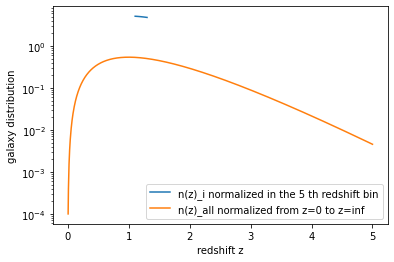

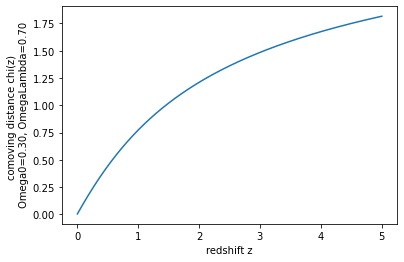

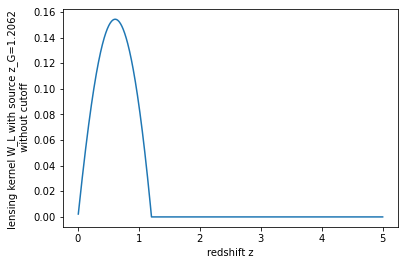

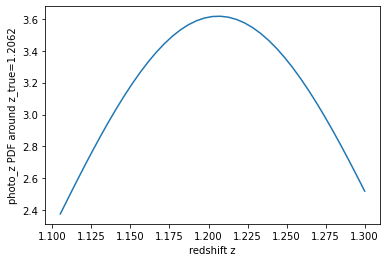

total area under the gaussian curve = 0.619
CPU times: user 793 ms, sys: 28.5 ms, total: 822 ms
Wall time: 822 ms


In [24]:
%%time 
#~15sec per redshift bin

#Ranges and values
#n_z_i_list     vs.   z_i_list
#n_z_all_list   vs.   z_list
#chi_list       vs.   z_list
#W_L_list       vs.   z_list x z_list
#W_L_list[i]    =     Lensing kernel for source at z_list[i]
z_list = np.linspace(0,z_limit,z_limit*z_res)[1:]
z_i_list = np.linspace(z_lowerbound,z_upperbound,int(deltaz*z_res))[1:]
#throw away the first element to perform right Riemann sum to avoid 0 division

#redshift distributions
def n_z(z):
    return z*z*np.exp(-z/0.5)
#galaxy distribution normalized in bin i    
n_z_i_norm = intg.quad(n_z,z_lowerbound,z_upperbound)[0]
def n_z_i(z):
    return z*z*np.exp(-z/0.5)/n_z_i_norm
n_z_i_list = n_z_i(z_i_list)
#galaxy distribution normalized from 0 to infinity~z_limit
n_z_all_norm = intg.quad(n_z,0,z_limit)[0]
def n_z_all(z):
    return z*z*np.exp(-z/0.5)/n_z_all_norm
n_z_all_list = n_z_all(z_list)
plt.plot(z_i_list, n_z_i_list,label = 'n(z)_i normalized in the %1i th redshift bin'%i)
plt.plot(z_list, n_z_all_list,label = 'n(z)_all normalized from z=0 to z=inf')
plt.xlabel('redshift z')
plt.ylabel('galaxy distribution')
plt.yscale('log')
plt.legend()
plt.show()

#comoving distance function, in unit of c/H0
#Troxel and Ishak 2014 equation (8) without the factor of H0
chi_list = np.array([])
def chi_integrand(z):
    return 1/np.sqrt(Omega0*(1+z)**3+Omegak*(1+z)**2+OmegaLambda)
def chi(z):
    return intg.quad(chi_integrand,0,z)[0]
for z in z_list: chi_list = np.append(chi_list,chi(z))
plt.plot(z_list, chi_list)
plt.xlabel('redshift z')
plt.ylabel('comoving distance chi(z) \n Omega0=%1.2f, OmegaLambda=%1.2f' %(Omega0,OmegaLambda))
plt.show()

#Lensing Kernel List
#W_L_list[z_list,z_list]
W_L_list = np.empty((len(z_list),len(z_list)))
for z_G_index in range(len(z_list)):
    chi_G = chi_list[z_G_index]
    W_L_list[z_G_index] = 1.5*Omega0*(1+z_list)*chi_list*(1-chi_list/chi_G)
W_L_list[W_L_list<0]=0 #set negative entries to 0 (eqv. set chi_L>chi_G entries to 0)
    #test = W_L_list.clip(min=0) This is slightly slower than the above method
test_redshift_index = int(1.2*z_res)
plt.plot(z_list, W_L_list[test_redshift_index])
plt.xlabel('redshift z')
plt.ylabel('lensing kernel W_L with source z_G=%1.4f \n without cutoff' %(z_list[test_redshift_index]))
plt.show()

#Gaussian Photo-Z PDF
photozPDF = np.empty((len(z_list),len(z_i_list)))
for ztrue_index in range(len(z_list)):
    ztrue = z_list[ztrue_index]
    #std function as a linear in redshift
    #Zhang 2018 discusses when 0.05->0.03 accuracy improves by 2.3x on page 7 bottom right
    std = 0.05*(1+ztrue)
    #gaussian pdf
    prefector = 1/(np.sqrt(2*np.pi)*std)
    photozPDF[ztrue_index] = prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
test_redshift_index=int(1.2*z_res)
plt.plot(z_i_list, photozPDF[test_redshift_index])
plt.xlabel('redshift z')
plt.ylabel('photo_z PDF around z_true=%1.4f' %(z_list[test_redshift_index]))
plt.show()
print('total area under the gaussian curve = %1.3f'%(sum(photozPDF[test_redshift_index]/z_res))) 

In [7]:
# %%time
# eta = 0
# z_index = 99

# ################
# #Upper integral with out multiplying the volume element (canceled out when dividing)

# #the matrix corr. to n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
# psnn_2D = np.empty((len(z_i_list),len(z_i_list))) 
# for zGP_index in range(len(z_i_list)):
#     filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP<0
#     filterfunction[filterfunction<0]=0
#     filterfunction=filterfunction != 0 #False for entries zgP-zGP<0
#     psnn_2D[zGP_index] = n_z_i_list[zGP_index]*n_z_i_list*filterfunction*photozPDF[z_index]
# #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
# psnn_reduce_zgP = np.sum(psnn_2D,axis = 1)
# #Adding the z_G variable and double summation
# Wppsnn_2D = np.empty((len(z_list),len(z_i_list))) 
# for zG_index in range(len(z_list)):
#     Wppsnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*psnn_reduce_zgP
# Wppsnn_2D_sum = np.sum(Wppsnn_2D)

# ################
# #Lower integral with out multiplying the volume element (canceled out when dividing)

# #the matrix corr. to n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
# pnn_2D = np.empty((len(z_i_list),len(z_i_list))) 
# for zGP_index in range(len(z_i_list)):
#     pnn_2D[zGP_index] = n_z_i_list[zGP_index]*n_z_i_list*photozPDF[z_index]
# #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
# pnn_reduce_zgP = np.sum(pnn_2D,axis = 1)
# #Adding the z_G variable and double summation
# Wppnn_2D = np.empty((len(z_list),len(z_i_list))) 
# for zG_index in range(len(z_list)):
#     Wppnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*pnn_reduce_zgP
# Wppnn_2D_sum = np.sum(Wppnn_2D)

# eta += Wppsnn_2D_sum/Wppnn_2D_sum
# print(eta)

0.4190573446438225
CPU times: user 63 ms, sys: 7.37 ms, total: 70.4 ms
Wall time: 90.3 ms


In [37]:
%%time
#3.5 min for z_lim = 5
eta = 0
eta_z = np.empty(len(z_list))
for z_index in range(len(z_list)):#[int(1.2*z_res)]
    ################
    #Upper integral with out multiplying the volume element (canceled out when dividing)
    
    #the matrix corr. to n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
    psnn_2D = np.empty((len(z_i_list),len(z_i_list))) 
    for zGP_index in range(len(z_i_list)):
        filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP<0
        filterfunction[filterfunction<0]=0
        filterfunction=filterfunction != 0 #False for entries zgP-zGP<0
        psnn_2D[zGP_index] = n_z_i_list[zGP_index]*n_z_i_list*filterfunction*photozPDF[z_index]
    #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
    psnn_reduce_zgP = np.sum(psnn_2D,axis = 1)
    #print(psnn_reduce_zgP)
    #Adding the z_G variable and double summation
    Wppsnn_2D = np.empty((len(z_list),len(z_i_list))) 
    for zG_index in range(len(z_list)):
        Wppsnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*psnn_reduce_zgP
    Wppsnn_2D_sum = np.sum(Wppsnn_2D)

    ################
    #Lower integral with out multiplying the volume element (canceled out when dividing)

    #the matrix corr. to n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
    pnn_2D = np.empty((len(z_i_list),len(z_i_list))) 
    for zGP_index in range(len(z_i_list)):
        pnn_2D[zGP_index] = n_z_i_list[zGP_index]*n_z_i_list*photozPDF[z_index]
    #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
    pnn_reduce_zgP = np.sum(pnn_2D,axis = 1)
    #Adding the z_G variable and double summation
    Wppnn_2D = np.empty((len(z_list),len(z_i_list))) 
    for zG_index in range(len(z_list)):
        Wppnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*pnn_reduce_zgP
    Wppnn_2D_sum = np.sum(Wppnn_2D)
    
#    print(Wppnn_2D_sum,Wppnn_2D_sum)
    if Wppnn_2D_sum==0:
        increment = 0
    else:
        increment = 2*Wppsnn_2D_sum/Wppnn_2D_sum
    
    eta += increment
    eta_z[z_index] = increment
#    print(z_index)

CPU times: user 6.27 s, sys: 55.9 ms, total: 6.32 s
Wall time: 6.52 s


In [45]:
%%time
#3.5 min for z_lim = 5
eta = 0
eta_z = np.empty(len(z_list))
for z_index in range(len(z_list)):#[int(1.2*z_res)]
    ################
    #Upper integral with out multiplying the volume element (canceled out when dividing)
    #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
    psnn_zGP = np.empty(len(z_i_list))
    Wppsnn_2D = np.empty((len(z_list),len(z_i_list))) 
    #Lower integral with out multiplying the volume element (canceled out when dividing)
    #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
    pnn_zGP = np.empty(len(z_i_list))
    Wppnn_2D = np.empty((len(z_list),len(z_i_list))) 
    
    for zGP_index in range(len(z_i_list)):
        filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP<0
        filterfunction[filterfunction<0]=0
        filterfunction=filterfunction != 0 #False for entries zgP-zGP<0
        
        #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
        temp_vec = photozPDF[z_index]*n_z_i_list[zGP_index]*n_z_i_list
        psnn_zGP[zGP_index] = np.sum(temp_vec*filterfunction)
        #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
        pnn_zGP[zGP_index] = np.sum(temp_vec)
        
    #Adding the z_G variable and double summation
    for zG_index in range(len(z_list)):
        Wppsnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*psnn_zGP
        Wppnn_2D[zG_index]  = W_L_list[z_index,zG_index]*photozPDF[zG_index]*pnn_zGP
    Wppsnn_2D_sum = np.sum(Wppsnn_2D)
    Wppnn_2D_sum  = np.sum(Wppnn_2D) 

#    print(Wppnn_2D_sum,Wppnn_2D_sum)
    if Wppnn_2D_sum == 0: increment = 0
    else: increment = 2*Wppsnn_2D_sum/Wppnn_2D_sum
    
    eta += increment
    eta_z[z_index] = increment

CPU times: user 6.14 s, sys: 28.2 ms, total: 6.17 s
Wall time: 6.2 s


In [42]:
np.sum(np.array([[1,1,1,],[1,1,1]]))

6

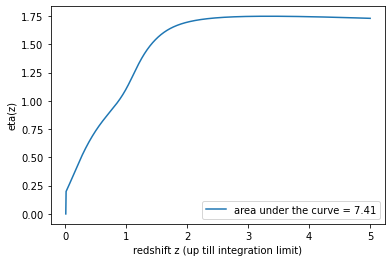

area under the curve = 7.41


In [47]:
#v2, z_res = 200, z_lim = 5, 6sec
plt.plot(z_list, eta_z,label='area under the curve = %1.2f'%(eta/z_res))
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('eta(z)')
plt.legend()
plt.show()
print('area under the curve = %1.2f'%(eta/z_res))

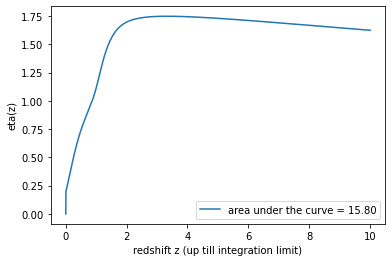

area under the curve = 15.7960281.2


In [22]:
#v2, z_res = 200, z_lim = 10, 24sec
plt.plot(z_list, eta_z,label='area under the curve = %1.2f'%(eta/z_res))
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('eta(z)')
plt.legend()
plt.show()
print('area under the curve = %f1.2'%(eta/z_res))

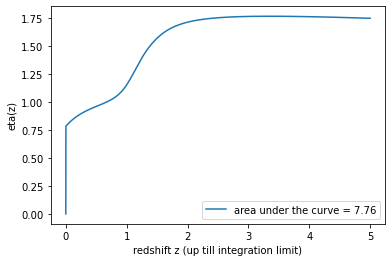

area under the curve = 7.7591781.2


In [11]:
#v1, z_res = 1000, z_lim = 5, 3.5min
plt.plot(z_list, eta_z,label='area under the curve = %1.2f'%(eta/z_res))
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('eta(z)')
plt.legend()
plt.show()
print('area under the curve = %f1.2'%(eta/z_res))

In [13]:
1.75*5-eta/z_res

0.9908217612753365

In [11]:
%%time
temp2D = ((n_z_i_2D.T)*photozPDF[99]).T

CPU times: user 350 µs, sys: 712 µs, total: 1.06 ms
Wall time: 1.52 ms


In [57]:
#for each z construct a 3D matrix of shape (z_G,z_gp,z_Gp)
#with cubic volume elements of vol = 1/z_res^3
#and compute W(z,z_G)p(z,z_gP)p(z_G)ni(z_Gp)ni(z_gp)
z_index = 6
upper_intg_arr = np.empty((len(z_i_list),len(z_i_list),len(z_list))) #(z_G,z_gp,z_Gp)
for zG_index in range(len(z_list)):
    for zgp_index in range(len(z_i_list)):
        filterfunction = z_i_list[zgp_index]-z_i_list
        filterfunction[filterfunction<0]=0
        filterfunction=filterfunction != 0 #(True for entries if zgP>zGP)

        upper_intg_arr[zG_index,zgp_index] = W_L_list[z_index,z_G_index]*photozPDF[zG_index]*photozPDF[z_index,zgp_index]*n_z_i_list*n_z_i_list[zgp_index]*filterfunction
        
print(sum(upper_intg_arr))
        
        
        
        
        
        

ValueError: could not broadcast input array from shape (199) into shape (19999)

In [4]:
W_L_list.shape

(19999, 19999)

In [11]:
np.array([1,2,3,4,5])*np.array([1,2,3,4,5])

array([ 1,  4,  9, 16, 25])

In [56]:
%%time
testzgp_index = 5
filterfunction = z_i_list[testzgp_index]-z_i_list
filterfunction[filterfunction<0]=0
filterfunction=filterfunction != 0
#filterfunction=1*filterfunction

CPU times: user 56 µs, sys: 0 ns, total: 56 µs
Wall time: 60.8 µs


In [49]:
print(z_i_list[testzgp_index])
print(z_i_list)
print(filterfunction)

1.1060301507537689
[1.10100503 1.10201005 1.10301508 1.1040201  1.10502513 1.10603015
 1.10703518 1.1080402  1.10904523 1.11005025 1.11105528 1.1120603
 1.11306533 1.11407035 1.11507538 1.1160804  1.11708543 1.11809045
 1.11909548 1.1201005  1.12110553 1.12211055 1.12311558 1.1241206
 1.12512563 1.12613065 1.12713568 1.1281407  1.12914573 1.13015075
 1.13115578 1.1321608  1.13316583 1.13417085 1.13517588 1.1361809
 1.13718593 1.13819095 1.13919598 1.14020101 1.14120603 1.14221106
 1.14321608 1.14422111 1.14522613 1.14623116 1.14723618 1.14824121
 1.14924623 1.15025126 1.15125628 1.15226131 1.15326633 1.15427136
 1.15527638 1.15628141 1.15728643 1.15829146 1.15929648 1.16030151
 1.16130653 1.16231156 1.16331658 1.16432161 1.16532663 1.16633166
 1.16733668 1.16834171 1.16934673 1.17035176 1.17135678 1.17236181
 1.17336683 1.17437186 1.17537688 1.17638191 1.17738693 1.17839196
 1.17939698 1.18040201 1.18140704 1.18241206 1.18341709 1.18442211
 1.18542714 1.18643216 1.18743719 1.18844221 1

In [6]:
%%time
for i in range(19999):
    for j in range(388):
        pass

CPU times: user 254 ms, sys: 4.05 ms, total: 258 ms
Wall time: 272 ms


In [33]:
test = np.array([1,2,3])
np.resize(test,(2,3,3))

array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]])

In [40]:
filterfunction

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])